In [1]:
# project: p5
# submitter: jstump
# partner: none
# hours: 7


In [2]:
import re
import requests
import pandas as pd
import netaddr
import edgar_utils as edgar
from subprocess import check_output 
import zipfile
from graphviz import Digraph, Graph
import geopandas as gpd
from shapely.geometry import Polygon, box, Point


In [3]:
zf = zipfile.ZipFile('server_log.zip')
zf.namelist()[0]
data = pd.read_csv(zf.open(zf.namelist()[0]))
data.head()


ip        date      time  zone        cik  \
0  104.197.32.ihd  2017-01-01  00:00:00   0.0  1111711.0   
1  208.77.214.jeh  2017-01-01  00:00:00   0.0   789019.0   
2  54.197.228.dbe  2017-01-01  00:00:00   0.0   800166.0   
3  108.39.205.jga  2017-01-01  00:00:01   0.0   354950.0   
4   52.45.218.ihf  2017-01-01  00:00:01   0.0  1313918.0   

              accession   extention   code     size  idx  norefer  noagent  \
0  0001193125-12-324016  -index.htm  200.0   7627.0  1.0      0.0      0.0   
1  0001193125-06-031505        .txt  200.0  46327.0  0.0      0.0      0.0   
2  0001279569-16-003038  -index.htm  200.0  16414.0  1.0      0.0      0.0   
3  0000950123-09-011236  -index.htm  200.0   8718.0  1.0      0.0      0.0   
4  0001209191-06-031555        .txt  200.0   8911.0  0.0      0.0      0.0   

   find  crawler  browser  
0  10.0      0.0      NaN  
1  10.0      0.0      NaN  
2  10.0      0.0      NaN  
3  10.0      0.0      NaN  
4  10.0      0.0      NaN

In [4]:
#Q1: what's the total size in bytes of the files requested?

size = data['size']
int(sum(size))

24801002666

In [5]:
#Q2: how many filings have been accessed by the top ten IPs?
ips = data.groupby(['ip']).size().sort_values(ascending = False)
top_10 = ips[:10]
top_10.to_dict()


{'54.152.17.ccg': 12562,
 '183.195.251.hah': 6524,
 '52.45.218.ihf': 5562,
 '68.180.231.abf': 5493,
 '204.212.175.bch': 4708,
 '103.238.106.gif': 4428,
 '208.77.215.jeh': 3903,
 '208.77.214.jeh': 3806,
 '217.174.255.dgd': 3551,
 '82.13.163.caf': 3527}

In [6]:
#Q3: what fraction of the requests had errors?

total = len(data['code'])
errors = sum(data['code'] >= 400)
errors/total

0.03466852724527611

In [7]:
#Q4: what is the most frequently accessed file?
files = []
for i in range(len(data)):
    cik = int(data['cik'][i])
    accession = data['accession'][i]
    ext = data['extention'][i]
    file = str(cik) + '/' + str(accession) + '/' + str(ext)
    files.append(file)
pd.Series(files).value_counts().index[0]

'1627631/0001627631-15-000004/.txt'

In [8]:
#Q5: how many requests were made by automated crawlers?

sum(data['crawler'] != 0.0)

971

In [9]:
#Q6: which region uses EDGAR most heavily?
regions = []
for item in data['ip']:
    region = edgar.lookup_region(item)
    regions.append(region)
pd.Series(regions).value_counts().index[0]



'United States of America'

In [10]:
#Q7: what fraction of IPs in each region are high-volume users?


ips = data.groupby(['ip']).size()
high_vol = ips[ips > 1000].index
high_vol_dict = {}

countries = pd.Series([edgar.lookup_region(ips.index[i]) for i in range(len(ips))]).value_counts()


for i in range(len(high_vol)):
    country = edgar.lookup_region(high_vol[i])
    if country not in high_vol_dict:
        high_vol_dict[country] = 1
    else:
        high_vol_dict[country] += 1
        

for country in countries.index:
    if country in high_vol_dict:
        high_vol_dict[country] = high_vol_dict[country] / countries[country]
    else:
        high_vol_dict[country] = 0.0
high_vol_dict
    


    
    

    



{'China': 0.006864988558352402,
 'India': 0.058823529411764705,
 'United States of America': 0.019862490450725745,
 'Australia': 0.07692307692307693,
 'France': 0.0036900369003690036,
 'United Kingdom of Great Britain and Northern Ireland': 0.06666666666666667,
 'Korea (Republic of)': 0.2,
 'Ireland': 0.3125,
 'Bulgaria': 0.3333333333333333,
 'Canada': 0.017857142857142856,
 'Germany': 0.0,
 'Hong Kong': 0.0,
 'Netherlands': 0.0,
 'Israel': 0.0,
 'Italy': 0.0,
 'Japan': 0.0,
 'Romania': 0.0,
 'Ukraine': 0.0,
 'Singapore': 0.0,
 'Taiwan (Province of China)': 0.0,
 'Russian Federation': 0.0,
 'Switzerland': 0.0,
 'Thailand': 0.0,
 'Spain': 0.0,
 'Viet Nam': 0.0,
 'South Africa': 0.0,
 'Poland': 0.0,
 'Egypt': 0.0,
 'Sweden': 0.0,
 'Brazil': 0.0,
 'Denmark': 0.0,
 'Philippines': 0.0,
 'Slovakia': 0.0,
 'Turkey': 0.0,
 'Czechia': 0.0,
 'Saudi Arabia': 0.0,
 'Indonesia': 0.0,
 'Malaysia': 0.0,
 'Estonia': 0.0,
 'Iraq': 0.0,
 'Tanzania, United Republic of': 0.0,
 'Austria': 0.0,
 'Luxembourg

In [11]:
files_dict = {}
with zipfile.ZipFile('docs.zip') as zf:
    for info in zf.infolist():
        with zf.open(info.filename) as f:
            html = f.read()
        files_dict[info.filename] = edgar.Filing(html.decode('utf-8'))
files_dict;

In [12]:
#Q8: what dates appear in the 850693/0000850693-07-000159/-index.htm file of docs.zip?
        
files_dict['850693/0000850693-07-000159/-index.htm'].dates



['2007-07-25', '2007-07-25', '2007-07-23']

In [13]:
#Q9: what is the distribution of states for the filings in docs.zip?

states = []
for key in files_dict:
    states.append(files_dict[key].state())
    
pd.Series(states).value_counts().to_dict()

{'CA': 91,
 'NY': 83,
 'TX': 64,
 'MA': 30,
 'PA': 25,
 'IL': 25,
 'CO': 25,
 'NJ': 23,
 'FL': 21,
 'MN': 15,
 'VA': 15,
 'CT': 14,
 'MD': 13,
 'MI': 11,
 'OH': 10,
 'DE': 10,
 'WI': 9,
 'NC': 9,
 'GA': 8,
 'OK': 7,
 'NV': 6,
 'IA': 6,
 'OX': 6,
 'AZ': 5,
 'KS': 5,
 'UT': 5,
 'TN': 4,
 'MO': 4,
 'IN': 4,
 'WA': 3,
 'WV': 2,
 'OR': 2,
 'LA': 2,
 'NE': 2,
 'KY': 2,
 'AL': 1,
 'SD': 1,
 'MS': 1,
 'VT': 1,
 'ID': 1,
 'AR': 1,
 'NM': 1,
 'DC': 1,
 'ME': 1}

In [14]:
#Q10: what is the distribution of SIC codes for the filings in docs.zip?

sic = []
for key in files_dict:
    sic.append(files_dict[key].sic)

pd.Series(sic).value_counts().to_dict()


{2834.0: 40,
 6021.0: 20,
 6798.0: 20,
 6022.0: 20,
 1311.0: 20,
 1389.0: 19,
 6211.0: 17,
 6189.0: 17,
 2836.0: 13,
 7389.0: 11,
 7372.0: 11,
 6029.0: 11,
 1000.0: 11,
 6331.0: 10,
 4911.0: 8,
 6282.0: 8,
 6199.0: 8,
 2860.0: 8,
 7370.0: 7,
 3841.0: 6,
 7371.0: 6,
 3674.0: 5,
 900.0: 5,
 4931.0: 5,
 3826.0: 5,
 4522.0: 5,
 1700.0: 5,
 8742.0: 5,
 6035.0: 4,
 4813.0: 4,
 3842.0: 4,
 2510.0: 4,
 3663.0: 4,
 7374.0: 4,
 5812.0: 4,
 3420.0: 3,
 6799.0: 3,
 3510.0: 3,
 8062.0: 3,
 1400.0: 3,
 3829.0: 3,
 2800.0: 3,
 7200.0: 3,
 7373.0: 3,
 6221.0: 3,
 3576.0: 3,
 3620.0: 3,
 3845.0: 2,
 2810.0: 2,
 1382.0: 2,
 4512.0: 2,
 7812.0: 2,
 3690.0: 2,
 3679.0: 2,
 5661.0: 2,
 7900.0: 2,
 5065.0: 2,
 4812.0: 2,
 3621.0: 2,
 5122.0: 2,
 3661.0: 2,
 3577.0: 2,
 1040.0: 2,
 2870.0: 2,
 1531.0: 2,
 6141.0: 2,
 3272.0: 2,
 3695.0: 2,
 3825.0: 2,
 2111.0: 2,
 8731.0: 2,
 3559.0: 2,
 5172.0: 2,
 4922.0: 2,
 4841.0: 2,
 5500.0: 2,
 1731.0: 2,
 6324.0: 2,
 6321.0: 2,
 8082.0: 2,
 5940.0: 2,
 3990.0: 2,
 59

In [15]:
#Q11: what is the distribution of requests across industries?
dist = []
for file in files:
    if file in files_dict.keys():
        dist.append(files_dict[file].sic)


pd.Series(dist).value_counts().to_dict()        

{2834.0: 984,
 1389.0: 656,
 1311.0: 550,
 2836.0: 429,
 6022.0: 379,
 1000.0: 273,
 6211.0: 237,
 7371.0: 229,
 2860.0: 226,
 6021.0: 204,
 2510.0: 171,
 6282.0: 171,
 3825.0: 164,
 4841.0: 108,
 5621.0: 99,
 7200.0: 94,
 7374.0: 94,
 6331.0: 91,
 5311.0: 90,
 6798.0: 90,
 3842.0: 87,
 6221.0: 85,
 6029.0: 83,
 3272.0: 81,
 3829.0: 73,
 4931.0: 70,
 3510.0: 66,
 7830.0: 62,
 3826.0: 56,
 3695.0: 55,
 3620.0: 50,
 7373.0: 48,
 6799.0: 46,
 4412.0: 43,
 4512.0: 42,
 7340.0: 40,
 900.0: 39,
 7370.0: 39,
 3621.0: 38,
 6513.0: 38,
 5172.0: 36,
 4213.0: 35,
 5900.0: 35,
 3990.0: 34,
 5122.0: 34,
 2070.0: 33,
 5944.0: 33,
 8090.0: 32,
 1700.0: 31,
 4922.0: 31,
 3312.0: 31,
 1381.0: 31,
 6324.0: 30,
 8742.0: 27,
 7389.0: 26,
 8731.0: 25,
 7812.0: 25,
 3590.0: 24,
 3663.0: 23,
 4955.0: 23,
 4522.0: 22,
 6321.0: 21,
 3559.0: 20,
 6792.0: 19,
 5812.0: 19,
 6189.0: 18,
 7372.0: 16,
 3841.0: 14,
 6199.0: 11,
 1731.0: 11,
 4911.0: 8,
 6035.0: 7,
 4833.0: 7,
 2430.0: 6,
 3571.0: 6,
 3674.0: 5,
 3679

In [16]:
#Q12: how many requests were made in each hour?
times = pd.to_datetime(data['time'])
hours = [i.hour for i in times]
pd.Series(hours).value_counts().sort_index().to_dict()


{0: 8305,
 1: 8242,
 2: 8550,
 3: 8850,
 4: 8343,
 5: 9783,
 6: 7761,
 7: 8213,
 8: 8292,
 9: 11033,
 10: 6377,
 11: 6435,
 12: 6155,
 13: 6006,
 14: 6654,
 15: 6512,
 16: 5680,
 17: 6487,
 18: 6356,
 19: 6211,
 20: 6066,
 21: 6164,
 22: 6098,
 23: 6283}

In [17]:
mapping = []

for i in range(len(data['ip'])):
    country = edgar.lookup_region(data['ip'][i])
    if country in ["Australia", "France", "Viet Nam"]:
        cik = int(data['cik'][i])
        accession = data['accession'][i]
        ext = data['extention'][i]
        file = str(cik) + '/' + str(accession) + '/' + str(ext)
        if file in files_dict:
            mapping.append((country, files_dict[file].state()))
        else:
            continue
    else:
        continue

mapping = list(set(mapping))

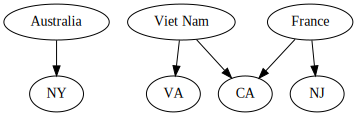

In [18]:
#Q13: what is the geographic overlap in interest between Australia, France, and Viet Nam?

nodes = [mapping[i][0] for i in range(len(mapping))]
edges = mapping
g = Digraph()
for item in edges:
    for i in item:
        g.node(i)
g.edges(edges)
g


In [19]:
#Q14: what are the most commonly seen street addresses?

addresses = []
all_addresses = []

for i in range(len(data['ip'])):
    cik = int(data['cik'][i])
    accession = data['accession'][i]
    ext = data['extention'][i]
    file = str(cik) + '/' + str(accession) + '/' + str(ext)
    if file in files_dict:
        addy = files_dict[file].addresses
        if len(addy) > 0:
            addresses.append(addy)
        else:
            continue
    else:
        continue


for item in addresses:
    for i in item:
        all_addresses.append(i)
        
series_addresses = pd.Series(all_addresses).value_counts()

series_addresses[series_addresses >= 225].to_dict()

    
        

{'801 CHERRY STREET\nSUITE 2100\nFORT WORTH TX 76102': 720,
 '801 CHERRY STREET\nSUITE 2100\nFORT WORTH TX 76102\n817-334-4100': 464,
 '1114 AVENUE OF THE AMERICAS\n29TH FLOOR\nNEW YORK NY 10036': 356,
 '1 SANSOME ST\n30TH FL\nSAN FRANCISCO CA 94104': 305,
 '10119 W. LARIAT LANE\nPEORIA AZ 85383': 289,
 '10119 W. LARIAT LANE\nPEORIA AZ 85383\n425-442-0931': 289,
 '1881 GROVE AVENUE\nRADFORD VA 24141': 277,
 '1 SANSOME ST\n30TH FL\nSAN FRANCISCO CA 94104\n3125066500': 264,
 '1251 AVENUE OF THE AMERICAS\nNEW YORK NY 10020': 225,
 '1251 AVENUE OF THE AMERICAS\nNEW YORK NY 10020\n212-956-2221': 225,
 '1177 WEST HASTINGS STREET\nSUITE 2300\nVANCOUVER A1 V6E 2K3': 225,
 '1177 WEST HASTINGS STREET\nSUITE 2300\nVANCOUVER A1 V6E 2K3\n604-683-6332': 225}

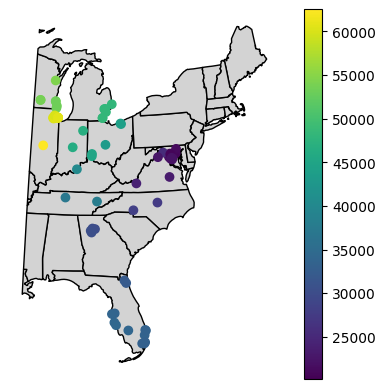

In [20]:
#Q15: geographic plotting of postal code
address = gpd.read_file('locations.geojson')
addresses = address['address']
zipcodes = []
for i in range(len(addresses)):
    item = addresses[i]
    if len(re.findall(r'[A-Z]{2} (\d{5})', item)) > 0:
        zipcodes.append(int(re.findall(r'[A-Z]{2} (\d{5})', item)[0]))
    else:
        zipcodes.append(0)

address['zipcodes'] = zipcodes

final_addresses = address[(address['zipcodes'] >= 20000) & (address['zipcodes'] <= 70000)]

west = -90
east = -55
north = 50
south = 20

window = box(west, south, east, north)

background = gpd.read_file("shapes/cb_2018_us_state_20m.shp").intersection(window).to_crs("epsg:2022")


point = final_addresses.intersection(window)     
point = point[~point.is_empty]


ax = background.plot(color = 'lightgray', edgecolor="k")
data1 = final_addresses.merge(point.rename("new_zipcode"), left_index=True, right_index= True)
point2 = data1.to_crs("epsg:2022")
point2.plot(ax=ax, cmap = "viridis", column = "zipcodes", legend = True)

ax.set_axis_off()


